In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [2]:
# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
validationset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
val_loader = DataLoader(validationset, batch_size=64, shuffle=True)


In [3]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

In [4]:
# creating model,and defining optimizer and loss
model = CNN()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [5]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [6]:
# defining the number of epochs
epochs = 7
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'accuracy':Accuracy(),
    'nll':Loss(criterion),
    'cm':ConfusionMatrix(num_classes=10)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [7]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

In [8]:
def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return -val_loss

handler = EarlyStopping(patience=100, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [9]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    validation_history['accuracy'].append(accuracy)
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)    


In [10]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    fig, ax = plt.subplots(figsize=(10,10))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

In [11]:
checkpointer = ModelCheckpoint('./saved_models', 'fashionMNIST', n_saved=2, create_dir=True, save_as_state_dict=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'fashionMNIST': model})


/home/wmnlab/anaconda3/envs/Yong-Tai/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Training Results - Epoch: 1  Avg accuracy: 88.63 Avg loss: 0.31
Validation Results - Epoch: 1  Avg accuracy: 87.64 Avg loss: 0.35
Training Results - Epoch: 2  Avg accuracy: 90.14 Avg loss: 0.26
Validation Results - Epoch: 2  Avg accuracy: 88.33 Avg loss: 0.31
Training Results - Epoch: 3  Avg accuracy: 91.19 Avg loss: 0.23
Validation Results - Epoch: 3  Avg accuracy: 89.19 Avg loss: 0.30
Training Results - Epoch: 4  Avg accuracy: 91.80 Avg loss: 0.22
Validation Results - Epoch: 4  Avg accuracy: 90.24 Avg loss: 0.28
Training Results - Epoch: 5  Avg accuracy: 93.19 Avg loss: 0.19
Validation Results - Epoch: 5  Avg accuracy: 90.57 Avg loss: 0.26
Training Results - Epoch: 6  Avg accuracy: 92.86 Avg loss: 0.19
Validation Results - Epoch: 6  Avg accuracy: 89.94 Avg loss: 0.27
Training Results - Epoch: 7  Avg accuracy: 94.26 Avg loss: 0.16
Validation Results - Epoch: 7  Avg accuracy: 90.86 Avg loss: 0.26


State:
	iteration: 6566
	epoch: 7
	epoch_length: 938
	max_epochs: 7
	output: 0.12291967123746872
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

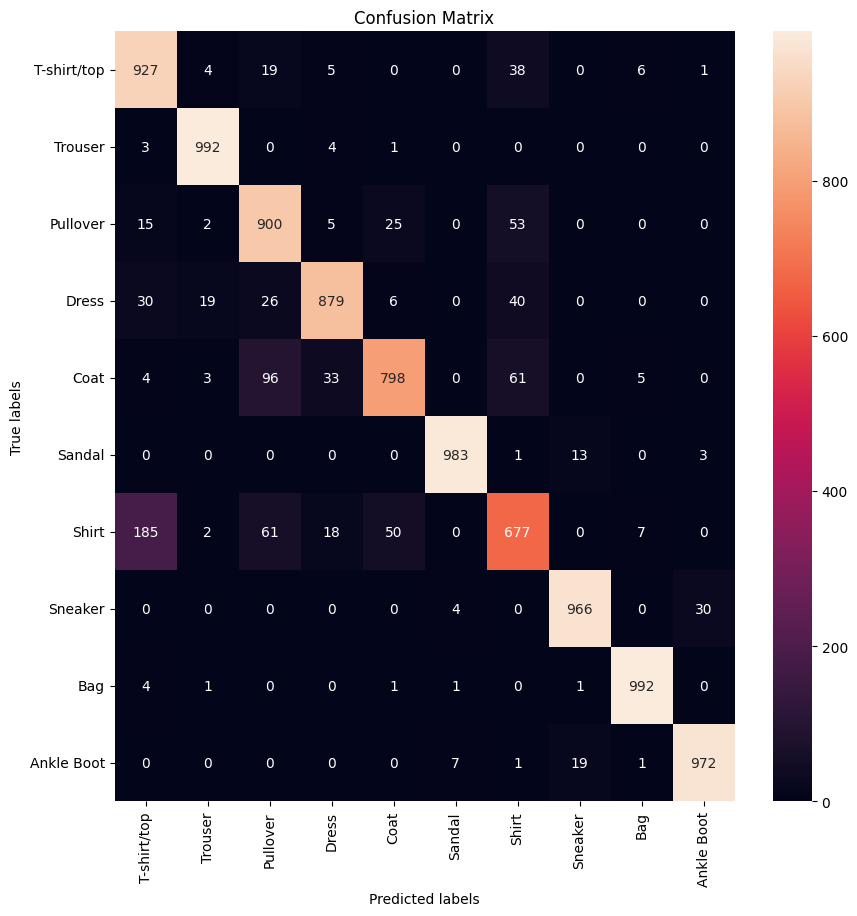

In [12]:
trainer.run(train_loader, max_epochs=epochs)

In [13]:
# creating model,and defining optimizer and loss
model = CNN()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [14]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

In [15]:
# defining the number of epochs
epochs = 7
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'accuracy':Accuracy(),
    'nll':Loss(criterion),
    'cm':ConfusionMatrix(num_classes=10)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history_adamW = {'accuracy':[],'loss':[]}
validation_history_adamW = {'accuracy':[],'loss':[]}
last_epoch = []

In [16]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

In [17]:
def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return -val_loss

handler = EarlyStopping(patience=100, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [18]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    last_epoch.append(0)
    training_history_adamW['accuracy'].append(accuracy)
    training_history_adamW['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    validation_history_adamW['accuracy'].append(accuracy)
    validation_history_adamW['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)    


In [19]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    fig, ax = plt.subplots(figsize=(10,10))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

In [20]:
checkpointer = ModelCheckpoint('./saved_models', 'fashionMNIST', n_saved=2, create_dir=True, save_as_state_dict=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'fashionMNIST': model})

Training Results - Epoch: 1  Avg accuracy: 89.74 Avg loss: 0.30
Validation Results - Epoch: 1  Avg accuracy: 88.47 Avg loss: 0.34
Training Results - Epoch: 2  Avg accuracy: 91.27 Avg loss: 0.24
Validation Results - Epoch: 2  Avg accuracy: 90.23 Avg loss: 0.29
Training Results - Epoch: 3  Avg accuracy: 92.80 Avg loss: 0.20
Validation Results - Epoch: 3  Avg accuracy: 90.98 Avg loss: 0.26
Training Results - Epoch: 4  Avg accuracy: 92.52 Avg loss: 0.21
Validation Results - Epoch: 4  Avg accuracy: 90.21 Avg loss: 0.28
Training Results - Epoch: 5  Avg accuracy: 93.33 Avg loss: 0.19
Validation Results - Epoch: 5  Avg accuracy: 90.75 Avg loss: 0.27
Training Results - Epoch: 6  Avg accuracy: 93.75 Avg loss: 0.17
Validation Results - Epoch: 6  Avg accuracy: 90.87 Avg loss: 0.26
Training Results - Epoch: 7  Avg accuracy: 94.19 Avg loss: 0.16
Validation Results - Epoch: 7  Avg accuracy: 90.92 Avg loss: 0.26


State:
	iteration: 6566
	epoch: 7
	epoch_length: 938
	max_epochs: 7
	output: 0.16597136855125427
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

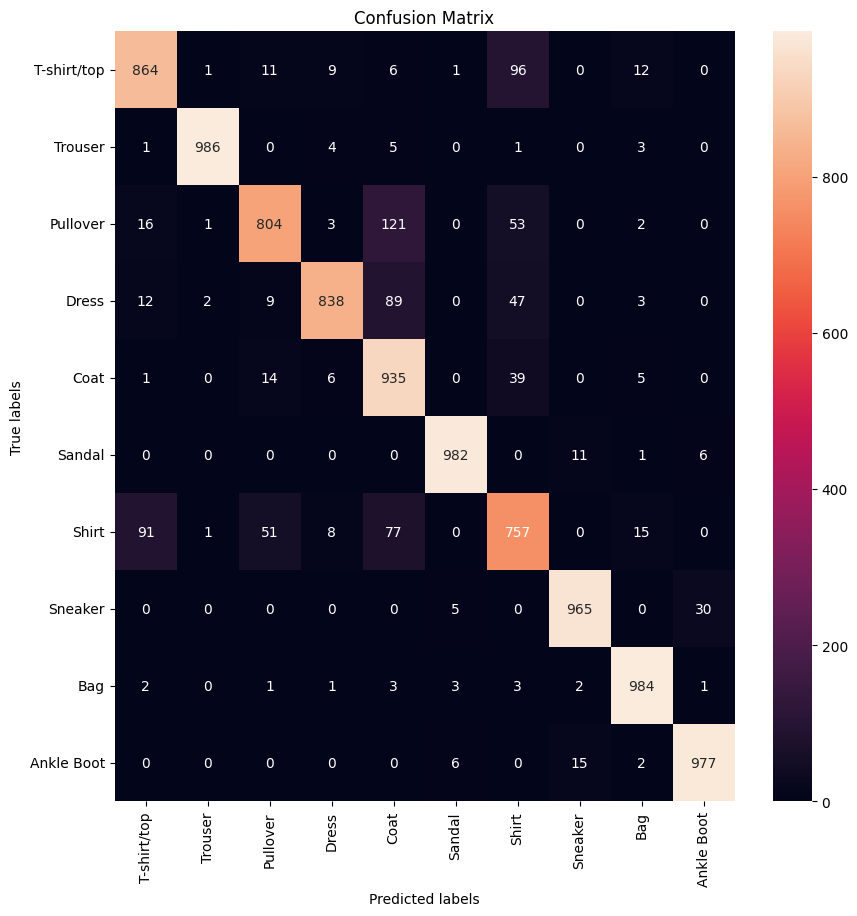

In [21]:
trainer.run(train_loader, max_epochs=epochs)

In [22]:
# creating model,and defining optimizer and loss
model = CNN()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

In [23]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

In [24]:
# defining the number of epochs
epochs = 7
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'accuracy':Accuracy(),
    'nll':Loss(criterion),
    'cm':ConfusionMatrix(num_classes=10)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history_adamL2 = {'accuracy':[],'loss':[]}
validation_history_adamL2 = {'accuracy':[],'loss':[]}
last_epoch = []

In [25]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

In [26]:
def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return -val_loss

handler = EarlyStopping(patience=100, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [27]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    last_epoch.append(0)
    training_history_adamL2['accuracy'].append(accuracy)
    training_history_adamL2['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    validation_history_adamL2['accuracy'].append(accuracy)
    validation_history_adamL2['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)    


In [28]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    fig, ax = plt.subplots(figsize=(10,10))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

In [29]:
checkpointer = ModelCheckpoint('./saved_models', 'fashionMNIST', n_saved=2, create_dir=True, save_as_state_dict=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'fashionMNIST': model})

Training Results - Epoch: 1  Avg accuracy: 87.14 Avg loss: 0.36
Validation Results - Epoch: 1  Avg accuracy: 85.75 Avg loss: 0.39
Training Results - Epoch: 2  Avg accuracy: 86.99 Avg loss: 0.37
Validation Results - Epoch: 2  Avg accuracy: 85.40 Avg loss: 0.40
Training Results - Epoch: 3  Avg accuracy: 88.11 Avg loss: 0.34
Validation Results - Epoch: 3  Avg accuracy: 86.97 Avg loss: 0.37
Training Results - Epoch: 4  Avg accuracy: 89.53 Avg loss: 0.31
Validation Results - Epoch: 4  Avg accuracy: 88.43 Avg loss: 0.34
Training Results - Epoch: 5  Avg accuracy: 88.70 Avg loss: 0.31
Validation Results - Epoch: 5  Avg accuracy: 87.45 Avg loss: 0.35
Training Results - Epoch: 6  Avg accuracy: 89.67 Avg loss: 0.30
Validation Results - Epoch: 6  Avg accuracy: 88.83 Avg loss: 0.33
Training Results - Epoch: 7  Avg accuracy: 87.87 Avg loss: 0.34
Validation Results - Epoch: 7  Avg accuracy: 86.94 Avg loss: 0.37


State:
	iteration: 6566
	epoch: 7
	epoch_length: 938
	max_epochs: 7
	output: 0.3453007638454437
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

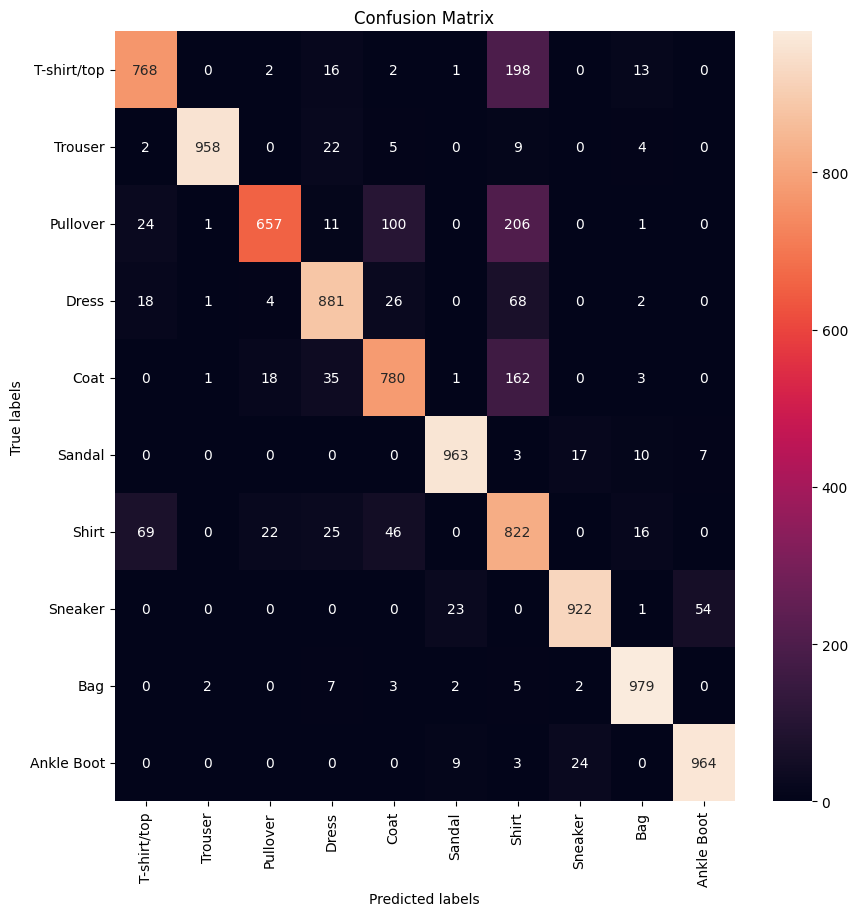

In [30]:
trainer.run(train_loader, max_epochs=epochs)

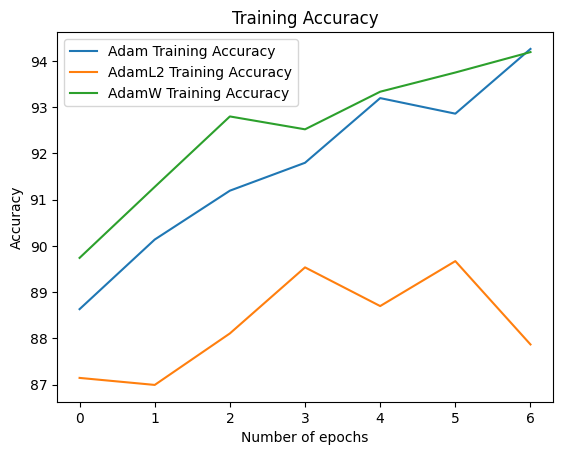

In [31]:
plt.plot(training_history['accuracy'],label="Adam Training Accuracy")
plt.plot(training_history_adamL2['accuracy'],label="AdamL2 Training Accuracy")
plt.plot(training_history_adamW['accuracy'],label="AdamW Training Accuracy")

plt.title('Training Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

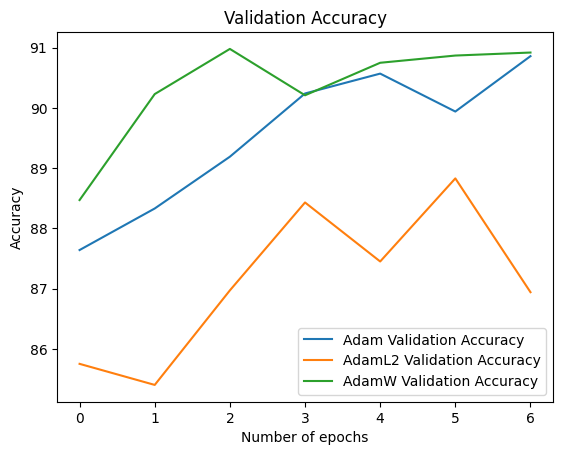

In [32]:
plt.plot(validation_history['accuracy'],label="Adam Validation Accuracy")
plt.plot(validation_history_adamL2['accuracy'],label="AdamL2 Validation Accuracy")
plt.plot(validation_history_adamW['accuracy'],label="AdamW Validation Accuracy")


plt.title('Validation Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

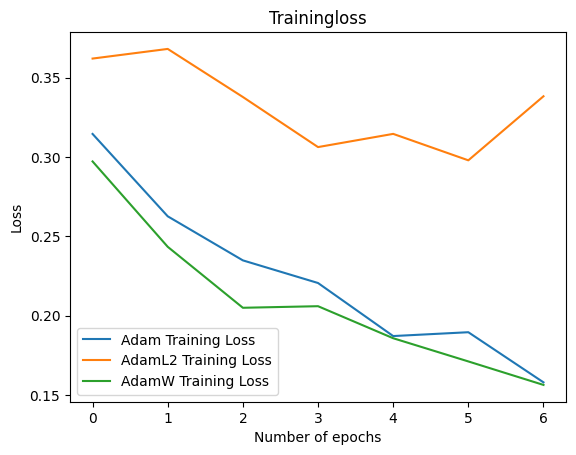

In [33]:
plt.plot(training_history['loss'],label="Adam Training Loss")
plt.plot(training_history_adamL2['loss'],label="AdamL2 Training Loss")

plt.plot(training_history_adamW['loss'],label="AdamW Training Loss")

plt.title('Trainingloss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

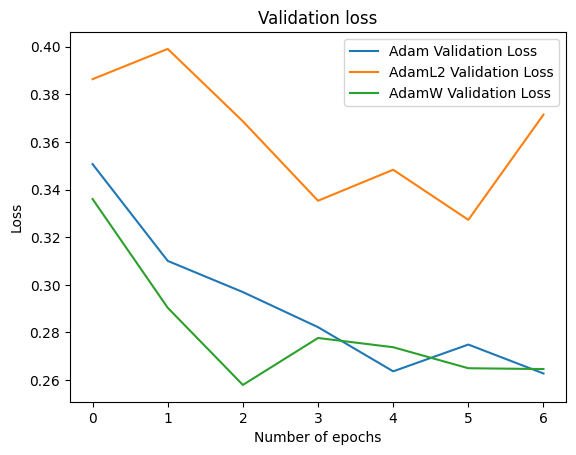

In [34]:
plt.plot(validation_history['loss'],label="Adam Validation Loss")
plt.plot(validation_history_adamL2['loss'],label="AdamL2 Validation Loss")
plt.plot(validation_history_adamW['loss'],label="AdamW Validation Loss")

plt.title('Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [35]:
# loading the saved model
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    from pathlib import Path
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return Path(model_save_path) / checkpoint_files[last_idx]

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('./saved_models')))
print("Model Loaded")

Model Loaded


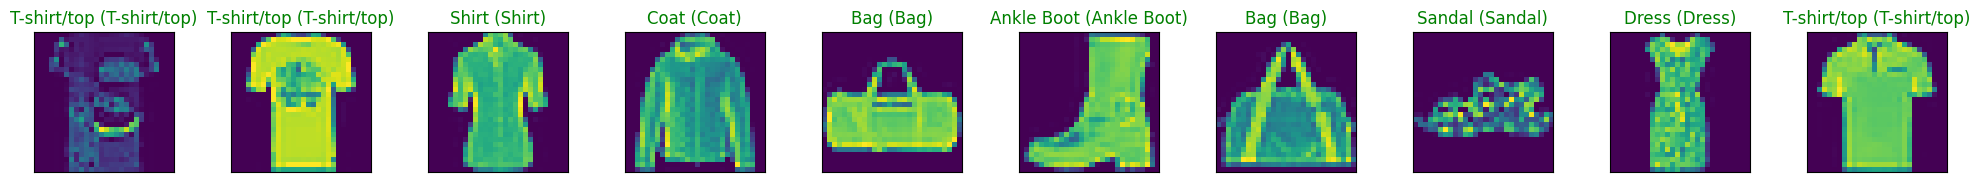

In [36]:
# classes of fashion mnist dataset
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
# creating iterator for iterating the dataset
dataiter = iter(val_loader)
images, labels = next(dataiter)
images_arr = []
labels_arr = []
pred_arr = []
# moving model to cpu for inference 
model.to("cpu")
# iterating on the dataset to predict the output
for i in range(0,10):
    images_arr.append(images[i].unsqueeze(0))
    labels_arr.append(labels[i].item())
    ps = torch.exp(model(images_arr[i]))
    ps = ps.data.numpy().squeeze()
    pred_arr.append(np.argmax(ps))
# plotting the results
fig = plt.figure(figsize=(25,4))
for i in range(10):
    ax = fig.add_subplot(2, int(20/2), i+1, xticks=[], yticks=[])
    ax.imshow(images_arr[i].resize_(1, 28, 28).numpy().squeeze())
    ax.set_title("{} ({})".format(classes[pred_arr[i]], classes[labels_arr[i]]),
                 color=("green" if pred_arr[i]==labels_arr[i] else "red"))


In [37]:
#https://github.com/pytorch/ignite/blob/master/examples/notebooks/FashionMNIST.ipynb